# 2.3 공식문서 따라하면 실패하는 Agentic RAG

- 이번 회차에서는 `conditional_edge`를 활용하는 방법을 배웁니다
    - `conditional_edge는` `LangGraph`에서 조건부 실행 흐름을 제어하는 특별한 종류의 엣지입니다. 
    - 일반 `edge`와 달리, 특정 조건이 충족될 때만 해당 경로로 실행이 진행됩니다.
- `conditional_edge는`는 주로 'if-then' 형태의 로직을 구현할 때 사용됩니다. 
    - 사용자의 입력이 특정 조건을 만족할 때만 특정 `node`로 이동하고, 그렇지 않으면 다른 경로로 진행하도록 설정할 수 있습니다
    - 'if-then'과 다른점은, if-else문을 사용하지 않고, LLM의 판단에 따라 경로를 제어한다는 점입니다

- LangGraph 공식문서에 나온 흐름을 따라갑니다
    - 공식문서를 따라가면 `rewrite`를 정상적으로 하지 않아 "살짝" 변형합니다
![agentic-rag](https://i.imgur.com/9NCNGWa.png)

In [16]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

- `state`를 선언하고 에이전트를 생성합니다
- 2.2강과 같이 RAG 파이프라인 구성이 목적이기 때문에 동일한 `state`를 사용합니다

In [17]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    
graph_builder = StateGraph(AgentState)

In [18]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [20]:
from langchain import hub

# RAG 프롬프트를 가져옵니다.
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state['context']  # state에서 문맥을 추출합니다.
    query = state['query']      # state에서 사용자의 질문을 추출합니다.
    
    # RAG 체인을 구성합니다.
    rag_chain = generate_prompt | llm
    
    # 질문과 문맥을 사용하여 응답을 생성합니다.
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}  # 생성된 응답을 포함하는 state를 반환합니다.

/Users/sangjinsu/projects/inflearn-langgraph-lecture/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- `conditional_edge`를 활용하여 문서 관련성을 판단하는 로직을 구현합니다
    - 에이전트는 LLM의 판단과 의사결정을 따릅니다

In [21]:
from langchain import hub
from typing import Literal

# 문서 관련성 판단을 위한 프롬프트를 가져옵니다.
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    context = state['context']  # state에서 문맥을 추출합니다.

    print(f"context: {context}")
    # 문서 관련성 판단 체인을 구성합니다.
    doc_relevance_chain = doc_relevance_prompt | llm
    
    # 질문과 문맥을 사용하여 문서의 관련성을 판단합니다.
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    print(f"response: {response}")
    # 관련성이 높으면 'generate'를 반환하고, 그렇지 않으면 'rewrite'를 반환합니다.
    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'

/Users/sangjinsu/projects/inflearn-langgraph-lecture/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [22]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 사전 정의: 특정 표현을 다른 표현으로 변환하기 위한 사전입니다.
dictionary = ['사람과 관련된 표현 -> 거주자']

# 프롬프트 템플릿을 생성합니다. 사용자의 질문을 사전을 참고하여 변경합니다.
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    
    # 리라이트 체인을 구성합니다. 프롬프트, LLM, 출력 파서를 연결합니다.
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문을 변경합니다.
    response = rewrite_chain.invoke({'query': query})
    
    return {'query': response}  # 변경된 질문을 포함하는 state를 반환합니다.

- `node`를 추가하고 `edge`로 연결합니다

In [23]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [24]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [25]:
graph = graph_builder.compile()

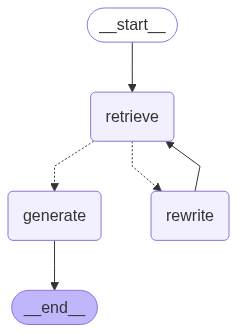

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- 질문을 변경해보면서 `rewrite` 노드가 활성화되는지 확인해보세요

In [27]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

context: [Document(id='0b3d724d-1048-4713-877a-9b3178256978', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'), Document(id='1dac7462-2ebd-4d73-9bb2-ad35da85dcc1', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입

{'query': '거주자의 연봉 5천만 원에 대한 세금은 어떻게 되나요?',
 'context': [Document(id='0b3d724d-1048-4713-877a-9b3178256978', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(id='1dac7462-2ebd-4d73-9bb2-ad35da85dcc1', metadata={'source': './documents/income_tax.txt'}, page_content='5년 